In [1]:
# gurobi free license only supports 2000 linear constraints, for higher n a (academic) license is needed
import gurobipy as gp
import numpy as np
from gurobipy import GRB
import matplotlib.pyplot as plt
from matplotlib import cm
import string
import seaborn as sns

In [2]:
def createmodel(n: int):
    model = gp.Model('nqueens')
    squares = model.addMVar((n, n, n), vtype=GRB.BINARY, name="x")
    model.setObjective(squares.sum(), GRB.MAXIMIZE)
    model.params.LogToConsole = 0  
    # row/file constraints:
    for i in range(n):
        for j in range(n):
            model.addConstr(squares[i, j, :].sum() <= 1)
            model.addConstr(squares[i, :, j].sum() <= 1)
            model.addConstr(squares[:, i, j].sum() <= 1)
    # diagonal constraints:
    for m in range(n):
        model.addConstrs(gp.quicksum(squares[i, j, m] for i in range(n) for j in range(n) if i - j == k) <= 1 for k in range(-n, n))
        model.addConstrs(gp.quicksum(squares[i, j, m] for i in range(n) for j in range(n) if i + j == k) <= 1 for k in range(2 * n))
        model.addConstrs(gp.quicksum(squares[i, m, j] for i in range(n) for j in range(n) if i - j == k) <= 1 for k in range(-n, n))
        model.addConstrs(gp.quicksum(squares[i, m, j] for i in range(n) for j in range(n) if i + j == k) <= 1 for k in range(2 * n))
        model.addConstrs(gp.quicksum(squares[m, i, j] for i in range(n) for j in range(n) if i - j == k) <= 1 for k in range(-n, n))
        model.addConstrs(gp.quicksum(squares[m, i, j] for i in range(n) for j in range(n) if i + j == k) <= 1 for k in range(2 * n))
    #triagonal constraints:
    model.addConstrs(gp.quicksum(squares[i, j, m] for i in range(n) for j in range(n) for m in range(n) if i - j == k and j-m==l) <= 1 for k in range(-n, n) for l in range(-n,n))
    model.addConstrs(gp.quicksum(squares[i, j, m] for i in range(n) for j in range(n) for m in range(n) if i + j == k and j-m==l) <= 1 for k in range(0, 2*n) for l in range(-n,n))
    model.addConstrs(gp.quicksum(squares[i, j, m] for i in range(n) for j in range(n) for m in range(n) if i + j == k and j+m==l) <= 1 for k in range(0, 2*n) for l in range(0,2*n))
    model.addConstrs(gp.quicksum(squares[i, j, m] for i in range(n) for j in range(n) for m in range(n) if i - j == k and j+m==l) <= 1 for k in range(-n, n) for l in range(0,2*n))
    model.params.PoolSolutions = 10**6
    model.params.PoolGap = 0  
    return(model, squares)

In [3]:
def solve(n: int, model, squares):
    model.params.LogToConsole = 0   
    model.optimize()

In [4]:
def plot(n: int, squares):
    mode = 3 #different plot modes, wip
    
    for d in range(n):
        image = np.zeros(n*n)
        image = image.reshape((n, n))
        row_labels = range(n)
        col_labels = list(string.ascii_uppercase[0:n])
        if n > 26:
            col_labels = range(n)
        for i in range(n):
            for j in range(n):
                if (i+j)%2 == 0:
                    image[i,j] = 0.5
                if mode == 1 and squares.X[i,j,d] == 1:
                    image[i,j] = squares.X[i,j,d]+0.5
                if mode == 2 and squares.X[i,d,j] == 1:
                    image[i,j] = squares.X[i,d,j]+0.5
                if mode == 3 and squares.X[d,i,j] == 1:
                    image[i,j] = squares.X[d,i,j]+0.5
        plt.matshow(image)
        plt.xticks(range(n), col_labels)
        plt.yticks(range(n), row_labels)

    plt.show()

In [5]:
def plotdensity(n: int, squares, solution_count):
    #print('Queens placed: '+str(model.objVal))
    print('Number of solutions found: ' + str(solution_count))
    sumat = (np.zeros(n*n*n))
    
    for sol in range(solution_count):
        model.setParam(GRB.Param.SolutionNumber, sol)
        sumat = sumat + model.Xn
    sumat = sumat.reshape((n, n, n))

    for d in range(n):
        image = np.zeros(n*n)
        image = image.reshape((n, n))
        row_labels = range(n)
        col_labels = list(string.ascii_uppercase[0:n])
        if n > 26:
            col_labels = range(n)
        for i in range(n):
            for j in range(n):
                image[i,j] = sumat[d,i,j]
        
        image = np.rint(image)
        sns.set(rc = {'figure.figsize':(4,3)})
        sns.heatmap(image.astype(int), linewidths=.5, cmap="Blues", annot=True, fmt="d", vmin=0, vmax=sumat.max())
        plt.xticks(range(n), col_labels)
        plt.yticks(range(n), row_labels)
        plt.show()
    return np.rint(sumat)

Restricted license - for non-production use only - expires 2023-10-25


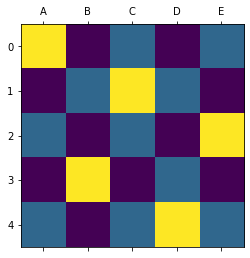

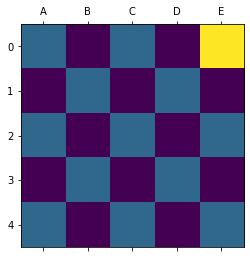

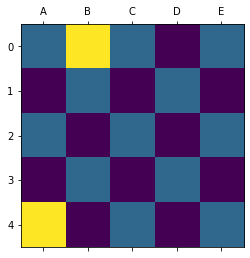

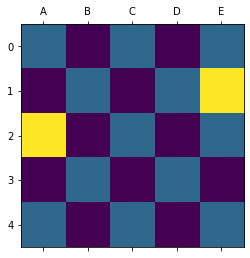

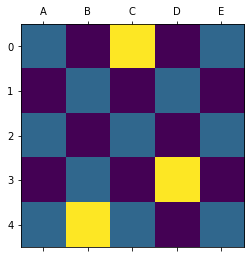

13.0

In [6]:
#example how to run the code
n = 5
model, squares = createmodel(n)
solve(n, model, squares)
plot(n, squares)
model.objVal

Queens placed: 1.0 in 0.0 sec
Queens placed: 1.0 in 0.00099945068359375 sec
Queens placed: 4.0 in 0.0014476776123046875 sec
Queens placed: 7.0 in 0.042285919189453125 sec
Queens placed: 13.0 in 0.4843559265136719 sec
Queens placed: 21.0 in 17.261341094970703 sec


<AxesSubplot:>

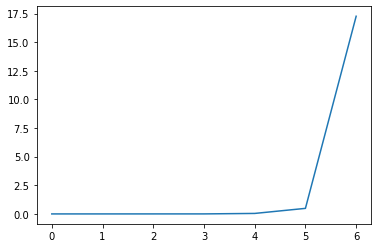

In [7]:
# runs the instances from n=l k and saves the results and runtimes
l = 1 #start
k = 6 #end
runtime = np.zeros((k+1,3))
for i in range(l,k+1):
    model, squares = createmodel(i)
    model.params.LogToConsole = 0
    solve(i, model, squares)
    runtime[i,1] = model.runtime
    runtime[i,2] = model.objVal
    runtime[i,0] = i
    print('Queens placed: '+str(model.objVal)+" in "+str(model.runtime)+" sec")
runtime  
sns.lineplot(y=runtime[:,1], x=runtime[:,0])

[None]

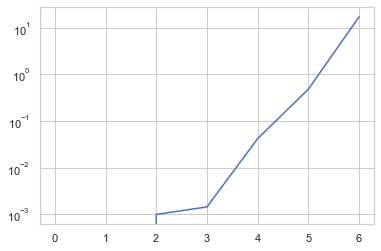

In [13]:
# log plot of runtimes
sns.set_style('whitegrid')
plt.figure(figsize=(6,4))
g_results=sns.lineplot(y=runtime[:,1], x=runtime[:,0],dashes=0)
g_results.set(yscale="log")

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-01-20
Number of solutions found: 16


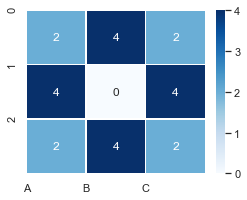

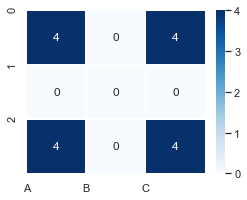

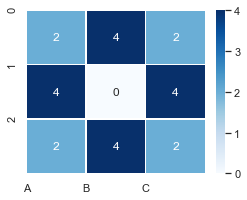

array([[[2., 4., 2.],
        [4., 0., 4.],
        [2., 4., 2.]],

       [[4., 0., 4.],
        [0., 0., 0.],
        [4., 0., 4.]],

       [[2., 4., 2.],
        [4., 0., 4.],
        [2., 4., 2.]]])

In [6]:
#plotting densities for n=3..7

n=3

model, squares = createmodel(n)
model.params.LogToConsole = 0
model.params.PoolSearchMode = 2
model.optimize()

densmat = plotdensity(n, model, model.SolCount)
densmat

Number of solutions found: 1344


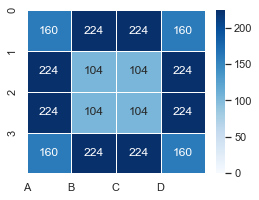

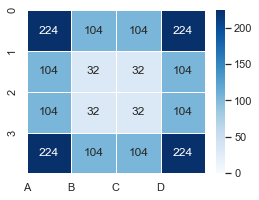

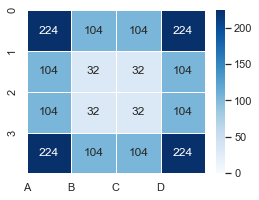

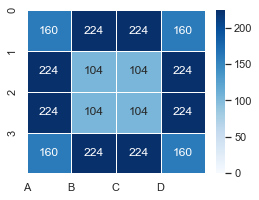

array([[[160, 224, 224, 160],
        [224, 104, 104, 224],
        [224, 104, 104, 224],
        [160, 224, 224, 160]],

       [[224, 104, 104, 224],
        [104,  32,  32, 104],
        [104,  32,  32, 104],
        [224, 104, 104, 224]],

       [[224, 104, 104, 224],
        [104,  32,  32, 104],
        [104,  32,  32, 104],
        [224, 104, 104, 224]],

       [[160, 224, 224, 160],
        [224, 104, 104, 224],
        [224, 104, 104, 224],
        [160, 224, 224, 160]]])

In [10]:
n=4

model, squares = createmodel(n)
model.params.LogToConsole = 0
model.params.PoolSearchMode = 2
model.optimize()

densmat = plotdensity(n, model, model.SolCount)
densmat

Number of solutions found: 1056


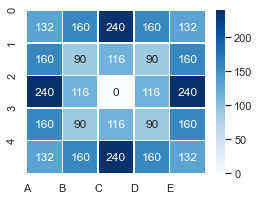

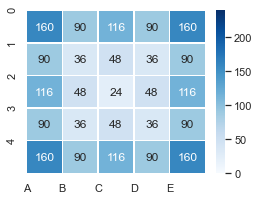

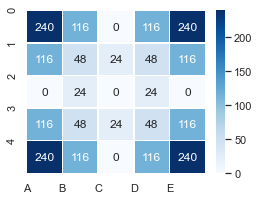

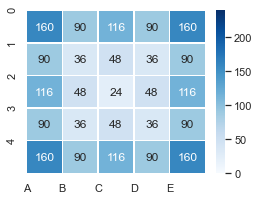

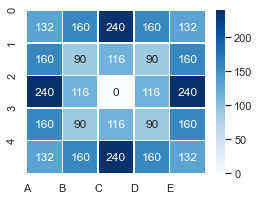

array([[[132., 160., 240., 160., 132.],
        [160.,  90., 116.,  90., 160.],
        [240., 116.,   0., 116., 240.],
        [160.,  90., 116.,  90., 160.],
        [132., 160., 240., 160., 132.]],

       [[160.,  90., 116.,  90., 160.],
        [ 90.,  36.,  48.,  36.,  90.],
        [116.,  48.,  24.,  48., 116.],
        [ 90.,  36.,  48.,  36.,  90.],
        [160.,  90., 116.,  90., 160.]],

       [[240., 116.,   0., 116., 240.],
        [116.,  48.,  24.,  48., 116.],
        [ -0.,  24.,   0.,  24.,  -0.],
        [116.,  48.,  24.,  48., 116.],
        [240., 116.,   0., 116., 240.]],

       [[160.,  90., 116.,  90., 160.],
        [ 90.,  36.,  48.,  36.,  90.],
        [116.,  48.,  24.,  48., 116.],
        [ 90.,  36.,  48.,  36.,  90.],
        [160.,  90., 116.,  90., 160.]],

       [[132., 160., 240., 160., 132.],
        [160.,  90., 116.,  90., 160.],
        [240., 116.,   0., 116., 240.],
        [160.,  90., 116.,  90., 160.],
        [132., 160., 240., 160.,

In [12]:
n=5

model, squares = createmodel(n)
model.params.LogToConsole = 0
model.params.PoolSearchMode = 2
model.optimize()

densmat = plotdensity(n, model, model.SolCount)
densmat

Number of solutions found: 912


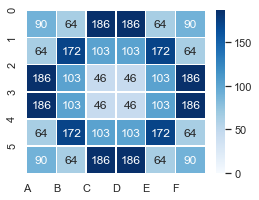

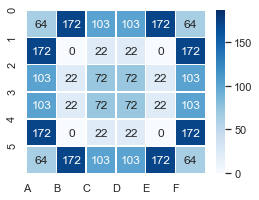

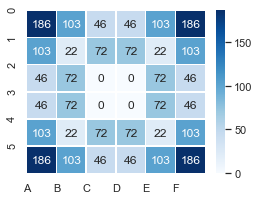

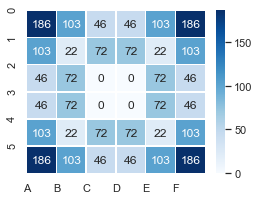

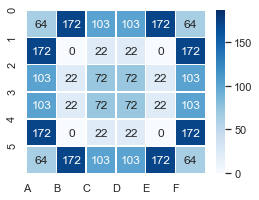

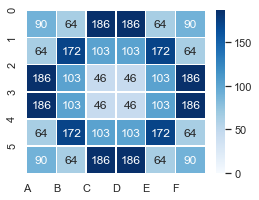

array([[[ 90.,  64., 186., 186.,  64.,  90.],
        [ 64., 172., 103., 103., 172.,  64.],
        [186., 103.,  46.,  46., 103., 186.],
        [186., 103.,  46.,  46., 103., 186.],
        [ 64., 172., 103., 103., 172.,  64.],
        [ 90.,  64., 186., 186.,  64.,  90.]],

       [[ 64., 172., 103., 103., 172.,  64.],
        [172.,   0.,  22.,  22.,  -0., 172.],
        [103.,  22.,  72.,  72.,  22., 103.],
        [103.,  22.,  72.,  72.,  22., 103.],
        [172.,   0.,  22.,  22.,  -0., 172.],
        [ 64., 172., 103., 103., 172.,  64.]],

       [[186., 103.,  46.,  46., 103., 186.],
        [103.,  22.,  72.,  72.,  22., 103.],
        [ 46.,  72.,  -0.,  -0.,  72.,  46.],
        [ 46.,  72.,   0.,   0.,  72.,  46.],
        [103.,  22.,  72.,  72.,  22., 103.],
        [186., 103.,  46.,  46., 103., 186.]],

       [[186., 103.,  46.,  46., 103., 186.],
        [103.,  22.,  72.,  72.,  22., 103.],
        [ 46.,  72.,   0.,  -0.,  72.,  46.],
        [ 46.,  72.,   0.,  

In [13]:
n=6

model, squares = createmodel(n)
model.params.LogToConsole = 0
model.params.PoolSearchMode = 2
model.optimize()

densmat = plotdensity(n, model, model.SolCount)
densmat

In [ ]:
n=7

model, squares = createmodel(n)
model.params.LogToConsole = 0
model.params.PoolSearchMode = 2
model.optimize()

densmat = plotdensity(n, model, model.SolCount)
densmat

In [8]:
model.runtime

3547.193328857422